https://lectures.quantecon.org/py/python_oop.html#oop-ex1

# eg Consumer Class

class Consumer() with wealth(data) attribute, .earn method, .spend method 

In [1]:
class Consumer:
    
    def __init__(self, w):
        "Initialize consumer with w dollars of wealth"
        self.wealth = w
        
    def earn(self, y):
        "The consumer earns y dollars"
        self.wealth += y
        
    def spend(self, x):
        "The consumer spends x dollars if feasable"
        new_wealth = self.wealth - x
        if new_wealth < 0:
            print("Insufficent funds")
        else:
            self.wealth = new_wealth

In [2]:
c1 = Consumer(10)
c1.spend(5)
c1.wealth

5

In [5]:
c1.earn(15)
c1.spend(100)

Insufficent funds


create multiple instances -- the fucking point of classes

In [6]:
c1 = Consumer(10)
c2 = Consumer(12)

c2.spend(4)
c2.wealth

8

In [8]:
c1.wealth

10

rules to self: 

    any instance data should be prepended with self
    
        eg the earn menod refs self.wealth rather than just wealth
        
    any method defined within the class should have self as its first argument
    
        eg def earn(self, y) rather than just def earn(y)
        
    any method referenced within the class should be called as self.method_name

In [9]:
print(Consumer.__dict__)

{'__module__': '__main__', '__init__': <function Consumer.__init__ at 0x104a2e6a8>, 'earn': <function Consumer.earn at 0x104a2e598>, 'spend': <function Consumer.spend at 0x104a2e158>, '__dict__': <attribute '__dict__' of 'Consumer' objects>, '__weakref__': <attribute '__weakref__' of 'Consumer' objects>, '__doc__': None}


In [10]:
# equivalent

c1.earn(10)

Consumer.earn(c1, 10)

# Solow Growth Model

$$k_{t+1}=szk^{α}_{t}+(1−δ)k_{t}/1+n$$

- s = exogenously given savings rate
- z = productivity 
- /alpha = capital's share of income
- n = population growth rate
- /delta = depreciation rate

the **steady state** is when $$k_{1 +1} = k_{1} = k$$

- An instance maintains a record of its current capital stock in the vaiable self.k
- The .h method implements the right hand side of the above equation
- The .update method uses .h to update daital as per the equation
 - Notice how inside update the reference to the local method .h is self.h

In [12]:
class Solow:
    """
    Implements the Solow growth model with update rule

        k_{t+1} = [(s z k^α_t) + (1 - δ)k_t] /(1 + n)

    """
    def __init__(self, n=0.05,  # population growth rate
                       s=0.25,  # savings rate
                       δ=0.1,   # depreciation rate
                       α=0.3,   # share of labor
                       z=2.0,   # productivity
                       k=1.0):  # current capital stock

        self.n, self.s, self.δ, self.α, self.z = n, s, δ, α, z
        self.k = k
        
    def h(self):
        'Evaluate the h function'
        # Unpack parameters (get rid of self to simplify notation)
        n, s, δ, α, z = self.n, self.s, self.δ, self.α, self.z
        # Apply the update rule
        return (s * z * self.k**α + (1 - δ) * self.k) / (1 + n)
    def update(self):
        "Update the current state (i.e., the capital stock)."
        self.k =  self.h()

    def steady_state(self):
        "Compute the steady state value of capital."
        # Unpack parameters (get rid of self to simplify notation)
        n, s, δ, α, z = self.n, self.s, self.δ, self.α, self.z
        # Compute and return steady state
        return ((s * z) / (n + δ))**(1 / (1 - α))

    def generate_sequence(self, t):
        "Generate and return a time series of length t"
        path = []
        for i in range(t):
            path.append(self.k)
            self.update()
        return path

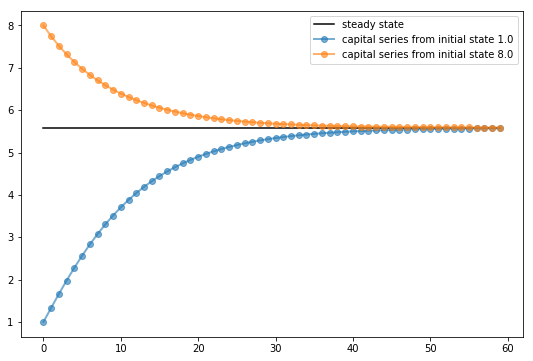

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

s1 = Solow()
s2 = Solow(k=8.0)

T = 60
fig, ax = plt.subplots(figsize=(9, 6))

# Plot the common steady state value of capital
ax.plot([s1.steady_state()]*T, 'k-', label='steady state')

# Plot time series for each economy
for s in s1, s2:
    lb = f'capital series from initial state {s.k}'
    ax.plot(s.generate_sequence(T), 'o-', lw=2, alpha=0.6, label=lb)

ax.legend()
plt.show()

## Example: A Market

Next let’s write a class for a simple one good market where agents are price takers

The market consists of the following objects:

A linear demand curve Q=ad−bdp
A linear supply curve Q=az+bz(p−t)
Here

p is price paid by the consumer, Q is quantity, and t is a per unit tax
Other symbols are demand and supply parameters
The class provides methods to compute various values of interest, including competitive equlibrium price and quantity, tax revenue raised, consumer surplus and producer surplus

Here’s our implementation

In [14]:
from scipy.integrate import quad

class Market:

    def __init__(self, ad, bd, az, bz, tax):
        """
        Set up market parameters.  All parameters are scalars.  See
        https://lectures.quantecon.org/py/python_oop.html for interpretation.

        """
        self.ad, self.bd, self.az, self.bz, self.tax = ad, bd, az, bz, tax
        if ad < az:
            raise ValueError('Insufficient demand.')

    def price(self):
        "Return equilibrium price"
        return  (self.ad - self.az + self.bz * self.tax) / (self.bd + self.bz)

    def quantity(self):
        "Compute equilibrium quantity"
        return  self.ad - self.bd * self.price()

    def consumer_surp(self):
        "Compute consumer surplus"
        # == Compute area under inverse demand function == #
        integrand = lambda x: (self.ad / self.bd) - (1 / self.bd) * x
        area, error = quad(integrand, 0, self.quantity())
        return area - self.price() * self.quantity()

    def producer_surp(self):
        "Compute producer surplus"
        #  == Compute area above inverse supply curve, excluding tax == #
        integrand = lambda x: -(self.az / self.bz) + (1 / self.bz) * x
        area, error = quad(integrand, 0, self.quantity())
        return (self.price() - self.tax) * self.quantity() - area

    def taxrev(self):
        "Compute tax revenue"
        return self.tax * self.quantity()

    def inverse_demand(self, x):
        "Compute inverse demand"
        return self.ad / self.bd - (1 / self.bd)* x

    def inverse_supply(self, x):
        "Compute inverse supply curve"
        return -(self.az / self.bz) + (1 / self.bz) * x + self.tax

    def inverse_supply_no_tax(self, x):
        "Compute inverse supply curve without tax"
        return -(self.az / self.bz) + (1 / self.bz) * x

In [16]:
baseline_params = 15, .5, -2, .5, 3
m = Market(*baseline_params)
print('equilibrium price = ', m.price())

equilibrium price =  18.5


In [17]:
print('consumer surplus = ', m.consumer_surp())

consumer surplus =  33.0625


Below, using Market class plot an inverse demand curve with inverse supply

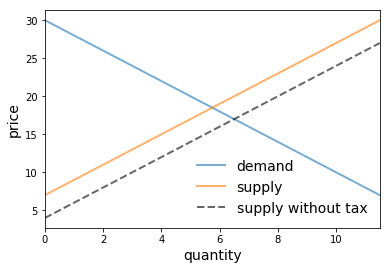

In [18]:
import numpy as np

# Baseline ad, bd, az, bz, tax
baseline_params = 15, .5, -2, .5, 3
m = Market(*baseline_params)

q_max = m.quantity() * 2
q_grid = np.linspace(0.0, q_max, 100)
pd = m.inverse_demand(q_grid)
ps = m.inverse_supply(q_grid)
psno = m.inverse_supply_no_tax(q_grid)

fig, ax = plt.subplots()
ax.plot(q_grid, pd, lw=2, alpha=0.6, label='demand')
ax.plot(q_grid, ps, lw=2, alpha=0.6, label='supply')
ax.plot(q_grid, psno, '--k', lw=2, alpha=0.6, label='supply without tax')
ax.set_xlabel('quantity', fontsize=14)
ax.set_xlim(0, q_max)
ax.set_ylabel('price', fontsize=14)
ax.legend(loc='lower right', frameon=False, fontsize=14)
plt.show()

The next program provides a function that

takes an instance of Market as a parameter
computes dead weight loss from the imposition of the tax

In [19]:
def deadw(m):
    "Computes deadweight loss for market m."
    # == Create analogous market with no tax == #
    m_no_tax = Market(m.ad, m.bd, m.az, m.bz, 0)
    # == Compare surplus, return difference == #
    surp1 = m_no_tax.consumer_surp() + m_no_tax.producer_surp()
    surp2 = m.consumer_surp() + m.producer_surp() + m.taxrev()
    return surp1 - surp2

In [20]:
baseline_params = 15, .5, -2, .5, 3
m = Market(*baseline_params)
deadw(m)  # Show deadweight loss

1.125

## Example Chaos

Let’s look at one more example, related to chaotic dynamics in nonlinear systems

One simple transition rule that can generate complex dynamics is the logistic map

xt+1=rxt(1−xt),x0∈[0,1],r∈[0,4](2)
Let’s write a class for generating time series from this model

Here’s one implementation

In [21]:
class Chaos:
  """
  Models the dynamical system with :math:`x_{t+1} = r x_t (1 - x_t)`
  """
  def __init__(self, x0, r):
      """
      Initialize with state x0 and parameter r
      """
      self.x, self.r = x0, r

  def update(self):
      "Apply the map to update state."
      self.x =  self.r * self.x *(1 - self.x)

  def generate_sequence(self, n):
      "Generate and return a sequence of length n."
      path = []
      for i in range(n):
          path.append(self.x)
          self.update()
      return path

In [22]:
ch = Chaos(0.1, 4.0)     # x0 = 0.1 and r = 0.4
ch.generate_sequence(5)  # First 5 iterates

[0.1, 0.36000000000000004, 0.9216, 0.28901376000000006, 0.8219392261226498]

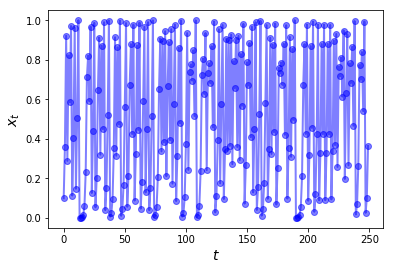

In [23]:
ch = Chaos(0.1, 4.0)
ts_length = 250

fig, ax = plt.subplots()
ax.set_xlabel('$t$', fontsize=14)
ax.set_ylabel('$x_t$', fontsize=14)
x = ch.generate_sequence(ts_length)
ax.plot(range(ts_length), x, 'bo-', alpha=0.5, lw=2, label='$x_t$')
plt.show()

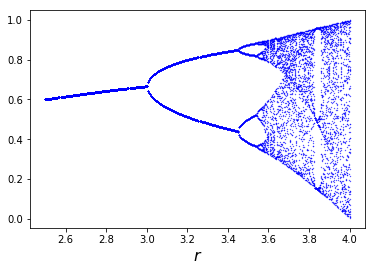

In [32]:
fig, ax = plt.subplots()
ch = Chaos(0.1, 4)
r = 2.5
while r < 4:
    ch.r = r
    t = ch.generate_sequence(1000)[950:]
    ax.plot([r] * len(t), t, 'b.', ms=0.6)
    r = r + 0.005

ax.set_xlabel('$r$', fontsize=16)
plt.show()

On the horizontal axis is the parameter r in (2)

The vertical axis is the state space [0,1]
For each r we compute a long time series and then plot the tail (the last 50 points)

The tail of the sequence shows us where the trajectory concentrates after settling down to some kind of steady state, if a steady state exists

Whether it settles down, and the character of the steady state to which it does settle down, depend on the value of r
For r between about 2.5 and 3, the time series settles into a single fixed point plotted on the vertical axis

For r between about 3 and 3.45, the time series settles down to oscillating between the two values plotted on the vertical axis

For r a little bit higher than 3.45, the time series settles down to oscillating among the four values plotted on the vertical axis

Notice that there is no value of r that leads to a steady state oscillating among three values

# Special Methods

if you want to return value for say len fxn when applied 

to your user-defined object, use __len__ magic method

In [33]:
class Foo:
    
    def __len__(self):
        return 42

In [34]:
f = Foo()
len(f)

42

to make instances callable use __call__

In [35]:
class Foo:
    
    def __call__(self, x):
        return x + 42

In [36]:
f = Foo()
f(8)


50